In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from unsupervised_random_forest import urf
from sklearn.manifold import MDS
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
# Change to correct working directory
os.chdir('C:\\Users\\xmste\\OneDrive\\Documents\\Systems Biology\\Year 2\\Scientific Programming\\Project\\SP_squirrels')

# Check working directory
os.getcwd()

'C:\\Users\\xmste\\OneDrive\\Documents\\Systems Biology\\Year 2\\Scientific Programming\\Project\\SP_squirrels'

# Load and explore squirrel dataset
In this section, the squirrel dataset is loaded and various aspects of it are explored.

In [3]:
# Read dataset
squirrels_raw = pd.read_csv('nyc_squirrels.csv')

First, the column containing 'other activities' is explored, to see if there are any particularities to be known about.

In [4]:
# Get other activities that are not NaN
pd.set_option('display.max_rows', None) # display all columns

other_activities_notnan = squirrels_raw["Other Activities"][squirrels_raw["Other Activities"].notnull()]

From the entries in Other Activities, it can be seen that squirrels 144 and 2041 are dead. Thus, these squirrels are removed from the dataset.

In [5]:
# Remove dead squirrels from data
squirrels = squirrels_raw.drop([144, 2041])
squirrels.reset_index(drop=True, inplace=True)

In [6]:
## Check if removing dead squirrels was succesful

# Check by seeing if dead squirrels still pop up in 'other activities' that are not NaN
other_activities_notnan_live = squirrels["Other Activities"][squirrels["Other Activities"].notnull()]
# print(other_activities_notnan_live)

# Check by printing shapes of original and cleaned data
print(squirrels_raw.shape)
print(squirrels.shape)

(3023, 31)
(3021, 31)


Next, we take a look at some of the variables in the dataset, so we know what values these variables can take and how they are distributed over all squirrels.

In [7]:
# Get column names
squirrels.columns

Index(['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color',
       'Highlight Fur Color', 'Combination of Primary and Highlight Color',
       'Color notes', 'Location', 'Above Ground Sighter Measurement',
       'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from',
       'Other Interactions', 'Lat/Long'],
      dtype='object')

In [8]:
# Get number of foraging squirrels
squirrels.Foraging.value_counts()

False    1586
True     1435
Name: Foraging, dtype: int64

In [9]:
# Get number of squirrels per fur color
squirrels['Primary Fur Color'].value_counts()

Gray        2472
Cinnamon     391
Black        103
Name: Primary Fur Color, dtype: int64

In [10]:
# Get number of approaching squirrels
squirrels['Approaches'].value_counts()

False    2843
True      178
Name: Approaches, dtype: int64

In [11]:
# Get number of squirrels per age
squirrels['Age'].value_counts()

Adult       2566
Juvenile     330
?              4
Name: Age, dtype: int64

In [12]:
# Get number of gray squirrels that are approaching humans
squirrels_gray = squirrels.loc[squirrels['Primary Fur Color'] == 'Gray']

# Calculate proportion of gray squirrels that approached people
squirrels_gray['Approaches'].value_counts().loc[True] / squirrels_gray['Approaches'].value_counts().loc[False]

0.05370843989769821

In [13]:
# Get number of cinnamon squirrels that are approaching humans
squirrels_cinnamon = squirrels.loc[squirrels['Primary Fur Color'] == 'Cinnamon']

# Calculate proportion of gray squirrels that approached people
squirrels_cinnamon['Approaches'].value_counts().loc[True] / squirrels_cinnamon['Approaches'].value_counts().loc[False]

0.12680115273775217

In [14]:
# Get number of black squirrels that are approaching humans
squirrels_black = squirrels.loc[squirrels['Primary Fur Color'] == 'Black']

# Calculate proportion of gray squirrels that approached people
squirrels_black['Approaches'].value_counts().loc[True] / squirrels_black['Approaches'].value_counts().loc[False]

0.061855670103092786

# Map squirrel locations
In this section, the location of squirrels can be mapped. This can be done for all squirrels or for various subsets of squirrels (e.g. only squirrels that are black, foraging, or something else). The maps are based on the hectares into which the park has been divided.

In [15]:
# TODO: look into dot size (does it now really give a good representation of distribution of squirrels?) 
# TODO: heatmap?

## Function for plotting number of squirrels per hectare in the park given a certain subset of squirrels

def plot_positions(squirrel_data):
    
    # Get number of squirrels per hectare
    squirrels_per_hectare = squirrel_data['Hectare'].value_counts()
    
    # Create figure
    plt.figure(figsize=(5,8))

    # Loop through hectares and plot dot relative to number of squirrels in that hectare
    # x-positions are saved by their ASCII value

    for hectare, n_squirrels in squirrels_per_hectare.items():
        y_coord = int(hectare[:2])
        x_coord = ord(hectare[2:])
        plt.scatter(x_coord, y_coord, color='blue', s=n_squirrels)
        
    plt.xticks([65, 66, 67, 68, 69, 70, 71, 72, 73], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])
    plt.show()

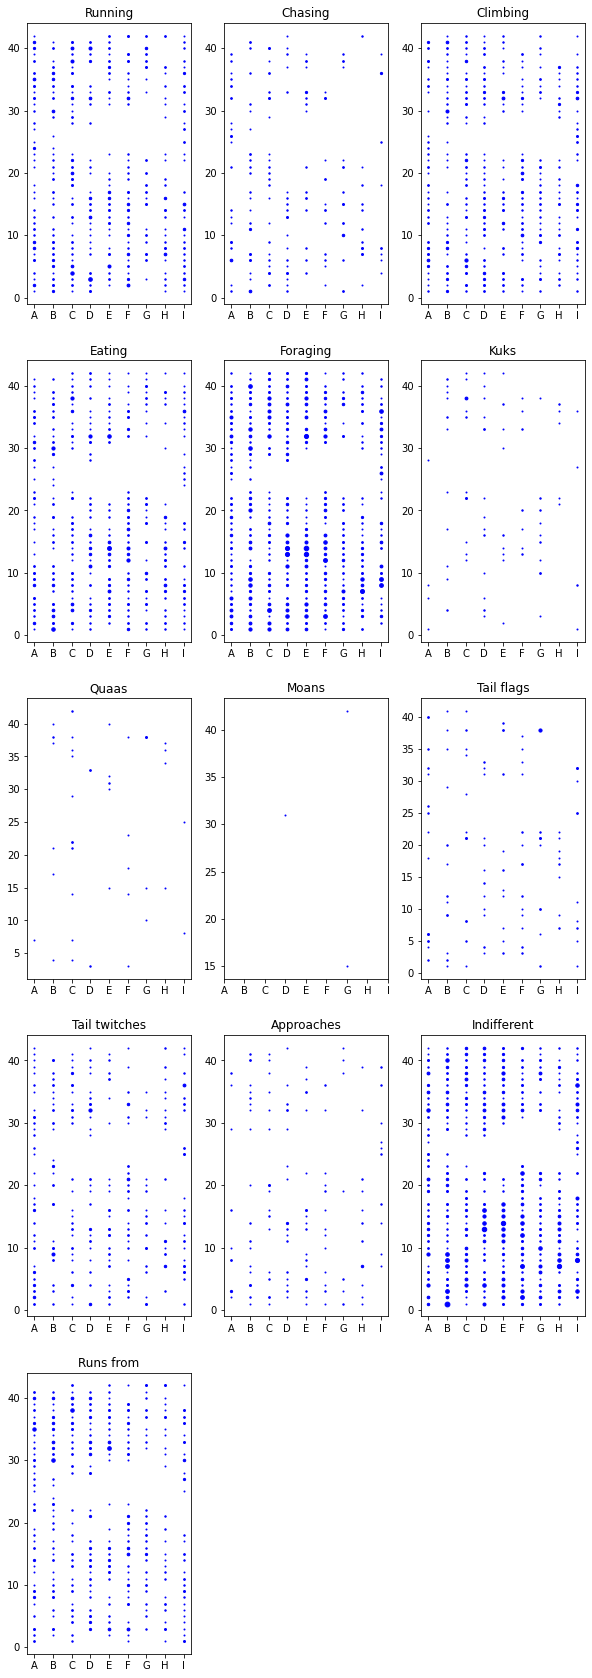

In [16]:
# Create plots of numbers of squirrels per hectare for all boolean variables

bool_vars = ['Running','Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans', 'Tail flags', 
             'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']

plt.figure(figsize=(10, 30))

# Loop over behaviors (boolean variables)
for n, var in enumerate(bool_vars):
    
    # add a new subplot iteratively
    ax = plt.subplot(5, 3, n + 1)
    
    # Get subset of data for all squirrels showing a certain behavior
    data = squirrels.loc[squirrels[var] == True]
    
    squirrels_per_hectare = data['Hectare'].value_counts()
    for hectare, n_squirrels in squirrels_per_hectare.items():
        y_coord = int(hectare[:2])
        x_coord = ord(hectare[2:])
        ax.scatter(x_coord, y_coord, color='blue', s=n_squirrels)
        
    ax.set_xticks([65, 66, 67, 68, 69, 70, 71, 72, 73], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])
    ax.set_title(var)

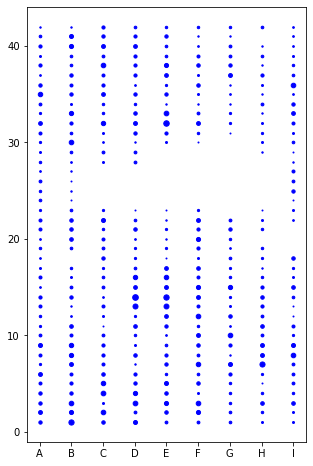

In [17]:
## Examples to make plots of non-boolean variables

# Plot positions of all squirrels
squirrel_plot = plot_positions(squirrels)

## Plot positions of all approaching gray squirrels
# squirrels_gray = squirrels.loc[squirrels['Primary Fur Color'] == 'Gray']
# plot_positions(squirrels_gray.loc[squirrels_gray['Approaches'] == True])

## Plot positions per fur color
# plot_positions(squirrels.loc[squirrels['Primary Fur Color'] == 'Gray'])
# plot_positions(squirrels.loc[squirrels['Primary Fur Color'] == 'Black'])
# plot_positions(squirrels.loc[squirrels['Primary Fur Color'] == 'Cinnamon'])

## Plot positions per shift
# plot_positions(squirrels.loc[squirrels['Shift'] == 'AM'])
# plot_positions(squirrels.loc[squirrels['Shift'] == 'PM'])

## Plot positions per location
# plot_positions(squirrels.loc[squirrels['Location'] == 'Ground Plane'])
# plot_positions(squirrels.loc[squirrels['Location'] == 'Above Ground'])

## Plot positions per Age
# plot_positions(squirrels.loc[squirrels['Age'] == 'Adult'])
# plot_positions(squirrels.loc[squirrels['Age'] == 'Juvenile'])

# Isolation forest

In this section, isolation forest is used on a subset of the variables to get the anomaly score per sample.

In [18]:
## Preprocessing

# Select columns to be used in isolation forest
isolation_columns = ['Hectare', 'Shift', 'Date', 'Age', 'Primary Fur Color', 'Location', 'Running',
                     'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans',
                     'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']

# Remove squirrels that have an NA entry in one of the columns to be used in isolation forest
squirrels = squirrels.dropna(subset=isolation_columns)
squirrels.reset_index(drop=True, inplace=True)

# Select subset of data with only columns to be used in isolation forest
squirrels_isolation = squirrels[isolation_columns]

Next, this subset of data will be label encoded so it can be used for further analysis.

In [114]:
# Label encode the data
le = LabelEncoder()
squirrels_encoded = squirrels_isolation.apply(lambda col: le.fit_transform(col))    

# Create isolation forest with 1000 trees and fit squirrel data over 5 runs
score_list = []

for i in range(5):
    rng = np.random.RandomState(42)
    clf = IsolationForest(n_estimators=1000, max_samples='auto', random_state=rng, contamination=0.1)

    clf.fit(squirrels_encoded)

    # Calculate anomaly scores from IF
    scores = clf.decision_function(squirrels_encoded)
    original_scores = [-1*s + 0.5 for s in scores]
    score_list.append(np.array(original_scores))
    
# Get average original paper score of 5 runs
original_paper_score = np.mean(score_list, axis = 0)

# Plot distribution of anomaly scores
# plt.bar(x = np.asarray(range(0, len(scores))), height = original_paper_score)

D:\programs\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
D:\programs\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
D:\programs\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
D:\programs\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
D:\programs\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


# Unsupervised random forest and Multidimensional Scaling

In this section, Unsupervised Random Forest (URF) is used on the label encoded data that was also used in Isolation Forest, to get a distance matrix for the samples. On this distance matrix, Multidimensional Scaling (MDS) will be performed to reduce dimensionality and visualize the samples. 

In [120]:
# Function to calculate mean distance matrix over 5 runs of URF
def urf_5(data):
    dist_list = []
    
    for i in range(5):
        urf_model = urf(n_trees=500, max_depth=3)
        distance_mat = urf_model.get_distance(data.to_numpy())
        dist_list.append(distance_mat)
        
    dist_mat_mean = np.mean(dist_list, axis = 0)
    
    return dist_mat_mean

In [121]:
# Get distance matrix averaged over 5 runs
squirrels_mean_dist_mat = urf_5(squirrels_encoded)

# Calculate PC scores from distance matrix using sklearn
embedding = MDS(n_components=2, dissimilarity='precomputed')
PC_scores_MDS = embedding.fit_transform(squirrels_mean_dist_mat)

PC_scores_MDS = pd.DataFrame(PC_scores_MDS)
# plt.scatter(PC_scores_MDS[0], PC_scores_MDS[1])

The calculated principal coordinates can be plotted against each other. This plot can then be colored with the anomaly scores calculated with Isolation Forest, to see were anomalies in the data are.

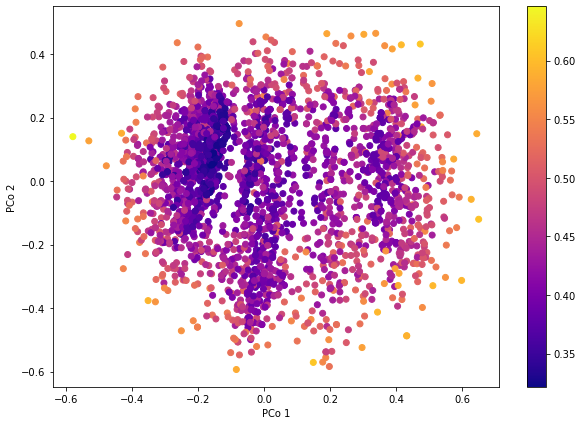

In [122]:
# Color PCoA plots by anomaly score from IF
f, ax = plt.subplots(figsize=(10, 7))
points = ax.scatter(PC_scores_MDS[0], PC_scores_MDS[1], c=list(original_paper_score), cmap='plasma')
ax.set_xlabel('PCo 1')
ax.set_ylabel('PCo 2')
f.colorbar(points)

# plt.savefig('IF_anomaly.png')

Next, the plot of the principal coordinates can be colored by different variables in the data.

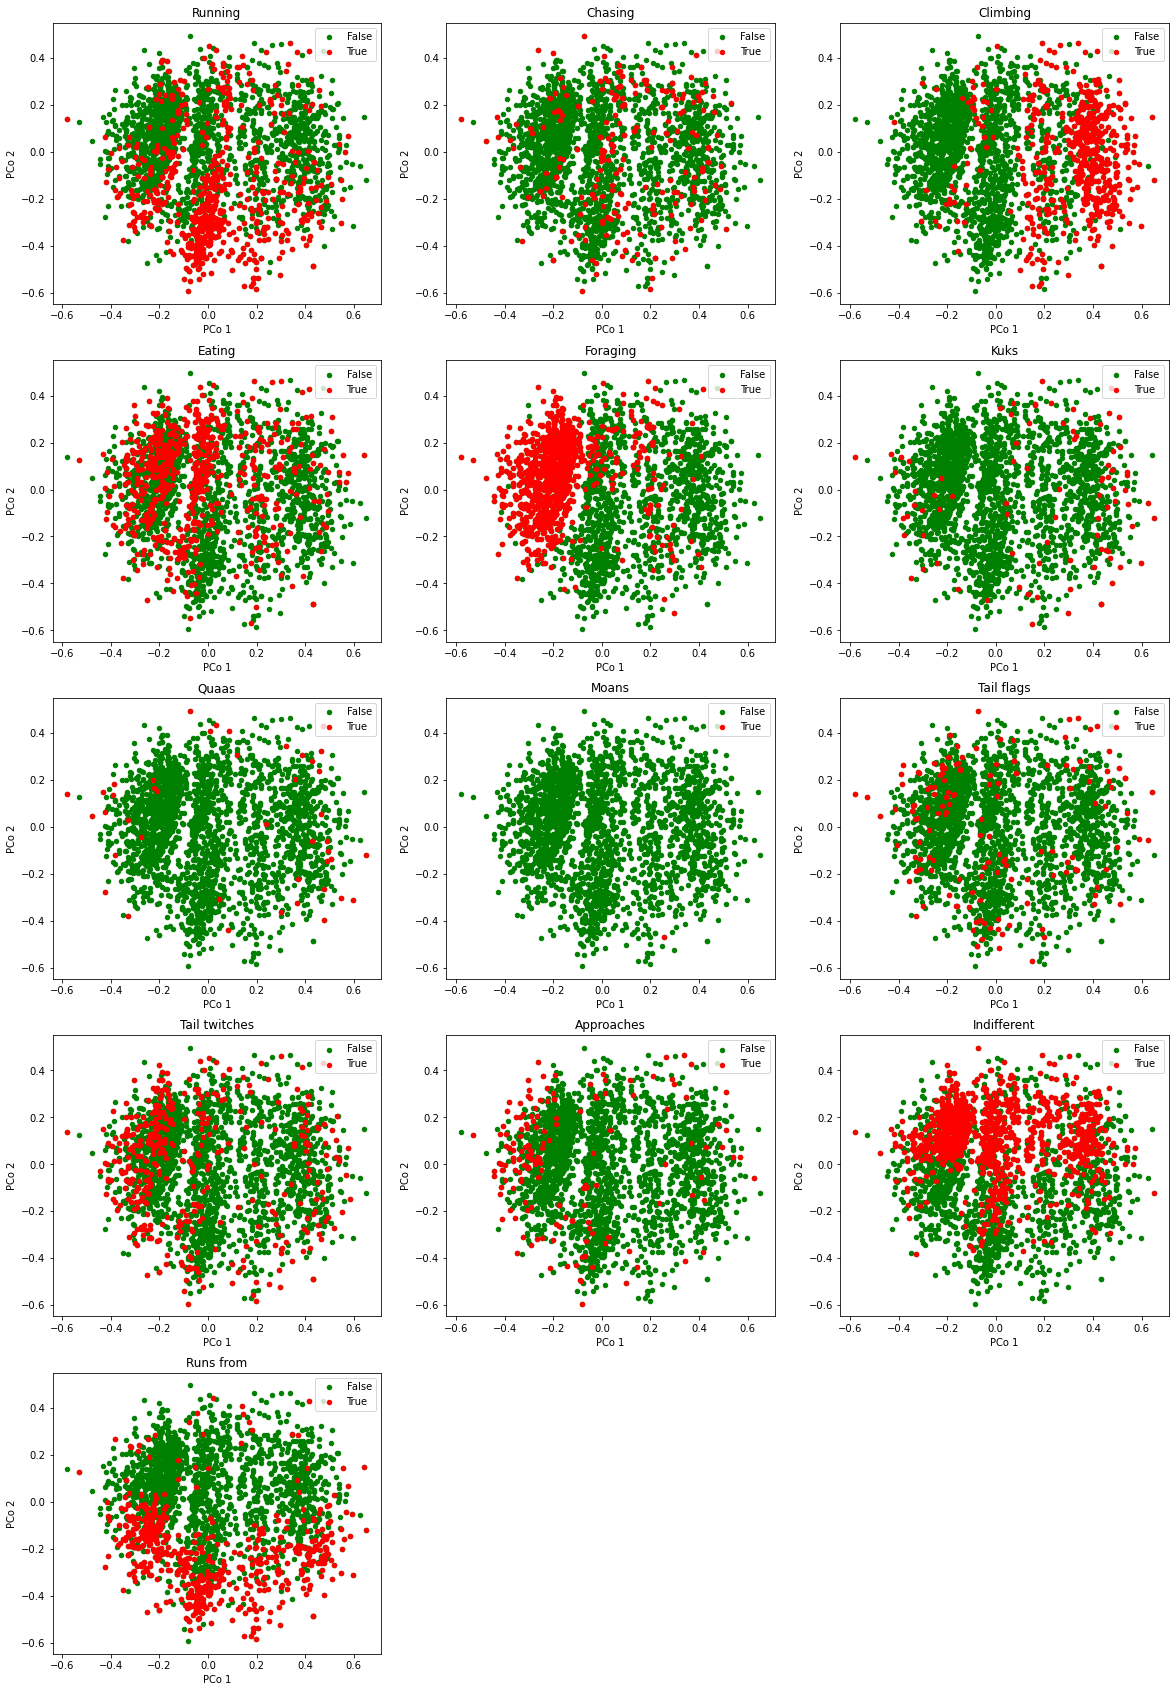

In [123]:
# Color PCo plot by boolean variables

bool_vars = ['Running','Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans', 'Tail flags', 
             'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']

plt.figure(figsize=(20, 30))
# plt.subplots_adjust(hspace=0.5)

# Make subplots in loop
for n, var in enumerate(bool_vars):
    
    # add a new subplot iteratively
    ax = plt.subplot(5, 3, n + 1)
    
    # Get list of squirrels for which variable is True
    true_ind = squirrels.index[squirrels[var] == True]

    # First plot all squirrels in green, then color squirrels with True values in red
    b1 = ax.scatter(PC_scores_MDS[0], PC_scores_MDS[1], c='green', s=20,label="False")
    b1 = ax.scatter(PC_scores_MDS.iloc[true_ind,0],PC_scores_MDS.iloc[true_ind,1], c='red',s=20,label="True")

    # chart formatting
    ax.set_title(var)
    plt.legend(loc="upper right")
    ax.set_xlabel('PCo 1')
    ax.set_ylabel('PCo 2')
    
# plt.savefig('PCo_bool_2.png')

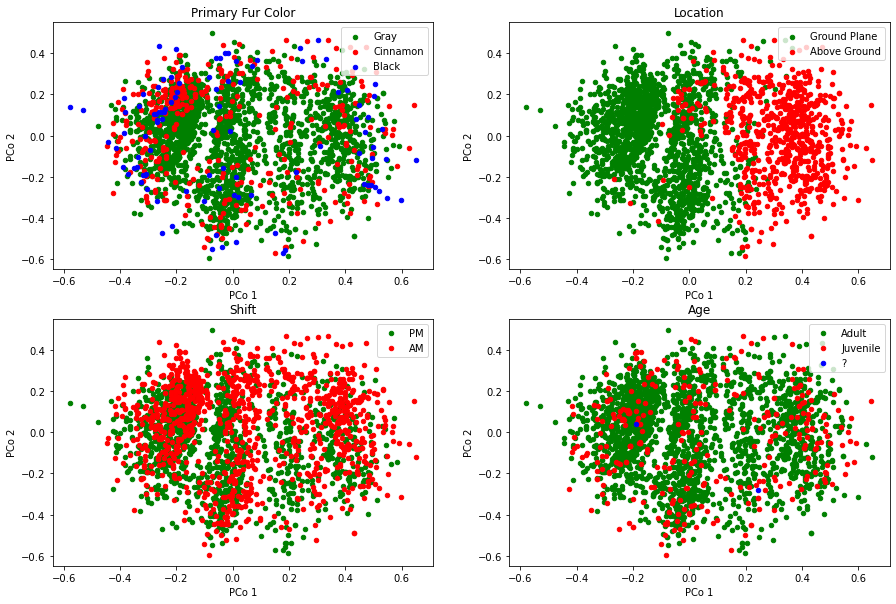

In [124]:
# Color PCo plots for non-boolean variables

plot_colors = ['green', 'red', 'blue']
nonbool_vars = ['Primary Fur Color', 'Location', 'Shift', 'Age']

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.2)

# Loop over non-boolean variables
for n, nonbool_var in enumerate(nonbool_vars):
    cats = squirrels[nonbool_var].value_counts()
    
    # Loop over values per variable
    for (item, n_squirrels), plot_col in zip(cats.items(), plot_colors):
        
        # add a new subplot iteratively
        ax = plt.subplot(2, 2, n + 1)

        # Get indices for squirrels of current value and plot these samples
        col_ind = squirrels.index[squirrels[nonbool_var] == item]
        ax.scatter(PC_scores_MDS.iloc[col_ind, 0], PC_scores_MDS.iloc[col_ind, 1], c=plot_col, s=20,label=item)

        # chart formatting
        ax.set_title(nonbool_var)
        plt.legend(loc="upper right")
        ax.set_xlabel('PCo 1')
        ax.set_ylabel('PCo 2')
        
# plt.savefig('PCo_nonbool.png')

# Try URF and MDS with transposed matrix

0     Text(-0.678712682918708, 0.08142692420996574, ...
1     Text(-0.09069436314838725, 0.24595736727117176...
2     Text(-0.6004351102222422, 0.1953701644597138, ...
3     Text(-0.4796730746287044, 0.05294299631288059,...
4     Text(-0.5759983479189617, 0.10232545379220503,...
5     Text(-0.2737272592702881, 0.15931104082757233,...
6     Text(0.2637533025179566, 0.10589768832281368, ...
7     Text(0.3191924540906296, -0.05263147058472598,...
8     Text(0.22211597335788993, -0.20644243726892642...
9     Text(0.16055993859828804, 0.0836966978711133, ...
10    Text(-0.11793904877931212, -0.0550268126524903...
11    Text(0.31048042009615706, -0.0813199913727157,...
12    Text(0.3097258798911198, -0.08815177240860146,...
13    Text(0.3066492889249674, -0.0845110608006674, ...
14    Text(0.2972887369355125, -0.08768351465619784,...
15    Text(0.23984127458327353, -0.11255241080975684...
16    Text(0.30372729043756924, -0.04267107900733847...
17    Text(-0.11573851674323361, -0.228573751383

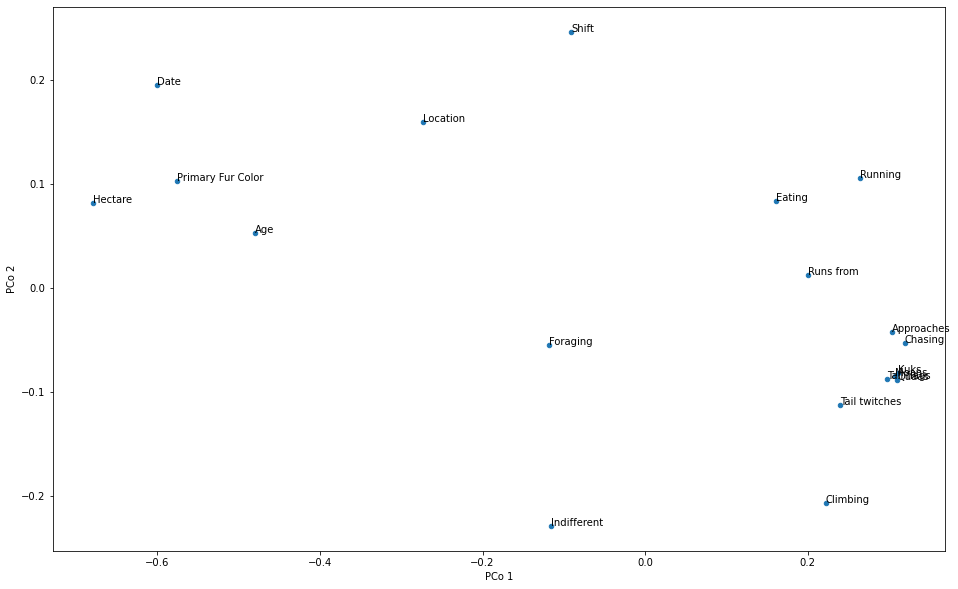

In [103]:
# Get mean distance matrix
dist_mat_mean = urf_5(squirrels_encoded.transpose())

# Calculate PC scores from distance matrix using sklearn
embedding_T = MDS(n_components=2, dissimilarity='precomputed')
PC_scores_MDS_T = embedding_T.fit_transform(dist_mat_mean)

PC_scores_MDS_T = pd.DataFrame(PC_scores_MDS_T)
PC_scores_MDS_T = PC_scores_MDS_T.rename(columns={0: 'PCo 1', 1: 'PCo 2'})
PC_scores_MDS_T['Variable'] = isolation_columns

ax = PC_scores_MDS_T.plot(x='PCo 1',y='PCo 2',kind='scatter',figsize=(16,10))
PC_scores_MDS_T[['PCo 1','PCo 2','Variable']].apply(lambda x: ax.text(*x),axis=1)

# Stuffs to try
- Use date: check for differences between weekdays and weekend and maybe holidays
- Use park data: maybe map rainy/cloudy days vs sunny days or color dots on map by busyness
- Mapping: look at dot size, maybe adjust, heat map?
- Try LPP: problem is, no idea on what I should do that (encoded data? Distance matrix?)
- Look into meaning of anomaly scores in URF
- Look into tweaking parameters (n_estimators, max_depth) for URF
- Look into function for isolation forest (threshold, n_estimators)
- Look into categorical PCA
- Look what more can be done with distance matrix from URF: kmeans?
- Get explained variance from MDS -> volgens mij kan da nie
- Look into anomaly scores from IF

# Questions

Get distance matrix from URF or IF
Check if matrix is similarity matrix, case if diagonal is 1
If similarity matrix, convert to distance matrix
Double centering on distance matrixprint(skbio.art).

Instead of pseudosamples: transpose input, so samples and variables are flipped, and then see if there are variables that cluster together

Run URF multiple times and then get average of distance matrices